In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import csv

In [17]:
# TODO: Alter function depending on format and interval of true data
def reduce_resolution(data, interval=1):
    
    interval_values = {}

    for timestamp, value in data:
        # Find which interval this timestamp belongs to
        interval_index = int(timestamp // interval)

        # If not in add it
        if interval_index not in interval_values:
            interval_values[interval_index] = value
        else:
            # If any value is 1, set the interval to 1
            interval_values[interval_index] = max(interval_values[interval_index], value)

    # Convert to sorted list of (timestamp, value) pairs
    reduced_data = []
    for interval_index in sorted(interval_values):
        reduced_timestamp = interval_index * interval
        reduced_value = interval_values[interval_index]
        reduced_data.append((reduced_timestamp, reduced_value))

    return reduced_data

def compute_confusion_matrix(sensor_data, true_data):
    # Assume sensor_data and true_data are same size and interval
    TP = FP = TN = FN = 0

    for i in range(len(sensor_data)):
        sensor_val = sensor_data[i][1]
        true_val = true_data[i][1]
        if sensor_val == 1 and true_val == 1:
            TP += 1
        elif sensor_val == 1 and true_val == 0:
            FP += 1
        elif sensor_val == 0 and true_val == 0:
            TN += 1
        elif sensor_val == 0 and true_val == 1:
            FN += 1

    confusion_matrix = np.array([
        [TP, FP],
        [FN, TN]
    ])
    return confusion_matrix

# compute accuracy and positive predictive value
def compute_metrics(confusion_matrix):
    TP = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    TN = confusion_matrix[1, 1]

    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0

    return accuracy, ppv


# Generate Synthetic Data for testing while circuit still being built

In [5]:
# !----------------- Generate synthetic data -----------------!

# Simulate 10 seconds worth of data with 1000 samples
sampling_rate = 100  # 100 samples per second

num_samples = 1000  # Total 1000 samples
interval_between_samples = 10 / num_samples  # 10 seconds divided by 1000 samples

# Generate synthetic data: (timestamp in seconds, biased random 0 or 1)
data = []
last_one_timestamp = -float('inf')  # Initialize to negative infinity
group_size = random.randint(50, 150)  # Randomize the number of consecutive 1s in a group to simulate vibration intensity

for i in range(num_samples):
    timestamp = i * interval_between_samples
    # Ensure 1 occurs only if at least 2 seconds have passed since the last group of 1s
    if timestamp - last_one_timestamp >= 2 and random.random() < 0.2:  # 20% chance to start a group of 1s
        for _ in range(group_size):
            if len(data) < num_samples:  # Ensure we don't exceed the total number of samples
                data.append((timestamp, 1))
                timestamp += interval_between_samples
        last_one_timestamp = timestamp - interval_between_samples
    else:
        data.append((timestamp, 0))  # Bias towards 0

# Write to CSV
with open('test_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['timestamp', 'value'])
    writer.writerows(data)

print("Sample data saved to 'test_data.csv'")


Sample data saved to 'test_data.csv'


In [6]:
f = pd.read_csv('test_data.csv', sep=',')
#print(f.head())


# Reduce resolution to 1 microsecond intervals
reduced_data = reduce_resolution(data, interval=0.5)

print("Reduced data:")
for timestamp, value in reduced_data:
    print(f"Timestamp: {timestamp:.6f}, Value: {value}")

Reduced data:
Timestamp: 0.000000, Value: 1
Timestamp: 0.500000, Value: 1
Timestamp: 1.000000, Value: 1
Timestamp: 1.500000, Value: 1
Timestamp: 2.000000, Value: 0
Timestamp: 2.500000, Value: 0
Timestamp: 3.000000, Value: 0
Timestamp: 3.500000, Value: 1
Timestamp: 4.000000, Value: 1
Timestamp: 4.500000, Value: 1
Timestamp: 5.000000, Value: 1
Timestamp: 5.500000, Value: 0
Timestamp: 6.000000, Value: 0
Timestamp: 6.500000, Value: 0
Timestamp: 7.000000, Value: 1
Timestamp: 7.500000, Value: 0
Timestamp: 8.000000, Value: 0
Timestamp: 8.500000, Value: 0
Timestamp: 9.000000, Value: 0
Timestamp: 9.500000, Value: 0


Accuracy: 1.00, PPV: 1.00


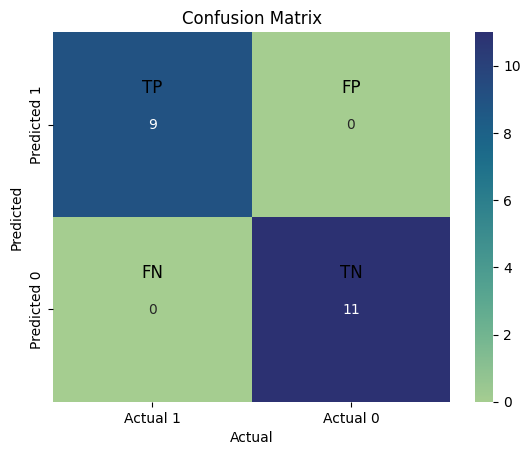

In [19]:
matrix = compute_confusion_matrix(reduced_data, reduced_data)
accuracy, ppv = compute_metrics(matrix)
print(f"Accuracy: {accuracy:.2f}, PPV: {ppv:.2f}")

# plot confusion matrix

sns.heatmap(matrix, annot=True, fmt="d", cmap="crest", 
            xticklabels=['Actual 1', 'Actual 0'], 
            yticklabels=['Predicted 1', 'Predicted 0'])

# Annotate each square with TP, FP, FN, TN slightly above the center
for i, label in enumerate(['TP', 'FP', 'FN', 'TN']):
    plt.text(i % 2 + 0.5, i // 2 + 0.3, label, ha='center', va='center', color='black', fontsize=12)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

